## Analysing recurrence types & task performance patterns

This notebook reproduces the analyses from the section _Recurrence types do not dissociate across visual manipulations_.

In [16]:
# General package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
import scipy
from scipy.stats import sem
from matplotlib.lines import Line2D

In [11]:
# Import some useful lists
external_list_file = '../data/external/lists.json'

# Read the json lists from the external list file
lists = json.load(open(external_list_file))

# Extract the relevant lists from the data
tasks = lists['tasks']
task_difficulty = lists['task_difficulty']
task_names = lists['task_names']
models = lists['models']
model_sizes = lists['model_sizes']
model_names = lists['model_names']
model_names_size_ordered = lists['model_names_size_ordered']
model_palette = lists['model_palette']

Define functions to extra confidence interval range and a star pattern from a p-value.

In [17]:
def get_CI_range(data, confidence=0.95):
  '''
  Output:
    Difference between the mean and the lower boundary of the 95% CI around the mean.
  '''
  confidence_interval = scipy.stats.norm.interval(
    alpha=confidence,
    loc=np.mean(data),
    scale=scipy.stats.sem(data)
  )
  
  interval = np.mean(data) - confidence_interval[0]
  
  return interval

def p_to_star(pvalue):
    '''Takes a p value and returns the corresponding significance stars.'''
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


Import the data

In [18]:
# Import the data
perf_data = pd.read_pickle('../data/processed/perf_vectors.pkl')

Parse it out.

In [19]:
## Parse the data for each analysis

# Extract average performance data
model_avg_seed = [[np.mean(perf_data[m][s]) for s in range(20)] for m in models]
models_avg = [np.mean(model_avg_seed[m]) for m in range(len(models))]
models_sem_seed = [sem(model_avg_seed[m]) for m in range(len(models))]
models_ci_seed = [get_CI_range(model_avg_seed[m]) for m in range(len(models))]
# Make an average performance data frame
avg_perf_df = pd.DataFrame({
    'model': models,
    'size': model_sizes.values(),
    'model_avg_performance': models_avg,
    'model_sem_seed': models_sem_seed,
    'model_ci_seed': models_ci_seed,
})

# Extract task-wise performance per model
task_perf = {
    m: {
        t: [perf_data[m][s][i] for s in range(20)]
    for i, t in enumerate(tasks)
    }
    for m in models
}
# Make an easy v challenging task aggregation
task_difficulty_perf = {
    m: {
        'easy': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='easy'],
        'challenging': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='hard']
    }
    for m in models
}
# Make an average per task of model performance
avg_task_perf = {
    m: {
        t: {
            'mean': np.mean([perf_data[m][s][i] for s in range(20)]),
            'sem': sem([perf_data[m][s][i] for s in range(20)]),
            'ci': get_CI_range([perf_data[m][s][i] for s in range(20)])
        }
    for i, t in enumerate(tasks)
    }
    for m in models
}
# Calculate the overall model average performance per task
model_task_wise = np.mean([[avg_task_perf[m][t]['mean'] for t in tasks] for m in models], axis=0)

Extract human data.

In [21]:
# Human performance-ordered task 
human_data = pd.read_pickle('../data/processed/human_bh_results.pkl')['data']
ordered_tasks = human_data['task']

# Extract human average performance
hum_avg_perf = human_data['average accuracy'].mean()
hum_avg_perf_nomask = human_data['no mask accuracy'].mean()
hum_avg_perf_mask = human_data['mask accuracy'].mean()

Define some styling elements.

In [22]:
# Define some styling elements
R_COLOUR = '#607A56' # One colour for recurrent models
FF_COLOUR = 'darkGray' # Another colour for non recurrent models
easy_colour = 'white'
hard_colour = 'black'
legend_fontsize = 10.0 # 18 for posters
marker_size = 3.0 # 10 for posters
err_bar_dict={
    'linewidth': 2.0,  # 12 for posters
    'capsize': 2.0,     # 4 for posters
}
# A colour for human results
hum_col = '#AADDFF'

Plotting figure 6A.

(0.1, 1.0)

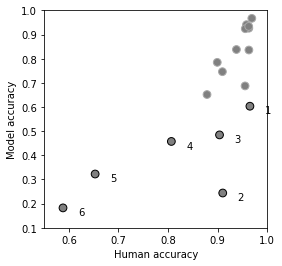

In [25]:
# Mark the outliers on the plot
outliers = ['scrambling_highpass', 'occlusion_many_small_blobs_high',
            'occlusion_many_small_partial_viewing_low',
            'occlusion_few_large_partial_viewing_high', 'scrambling_lowpass',
            'occlusion_many_small_partial_viewing_high']

# Make the figure
fig, ax = plt.subplots(figsize = (4.0, 4.0))
ax.scatter(
    x = perf_data['accuracy'],
    y = model_task_wise,
    color = 'gray',
    edgecolor=['darkGray' if not t in outliers else 'black' for t in tasks],
    linewidth=1.0,
    s=marker_size*20,
    clip_on=False
)
# Find where the outliers are in the list
outlier_idx = [tasks.index(o) for o in outliers]
# Extract the xy coordinates for each
outliers_xy = [(perf_data['accuracy'][i], model_task_wise[i]) for i in outlier_idx]
# Annotate the outliers on the plot
for i, _ in enumerate(outliers):
    x, y = outliers_xy[i]
    ax.text(x+0.03, y-0.03, i+1)

# Work the axes
ax.set_xlabel('Human accuracy')
ax.set_xlim(0.55, 1.0)
ax.set_ylabel('Model accuracy')
ax.set_ylim(0.1, 1.0)

Plotting figure 6B.

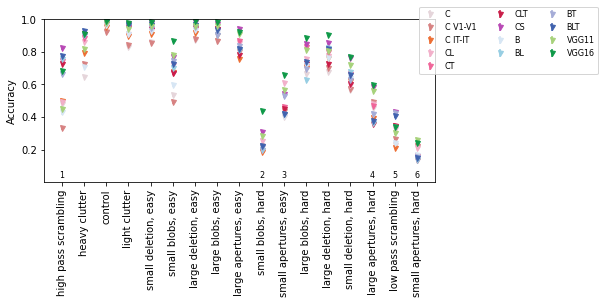

In [ ]:
## Task-wise pointplot

## Make a point plot with accuracy per model and per task
fig, ax = plt.subplots(figsize=(7.0, 3.0))

# Plot the data with error bars
x = np.arange(len(tasks))  # the label locations

for m in models:
    y_values = [avg_task_perf[m][t]['mean'] for t in ordered_tasks]
    yerr = [avg_task_perf[m][t]['sem'] for t in ordered_tasks]
    ax.errorbar(x, y_values, yerr=yerr, fmt='v',
                color=model_palette[m], label=model_names[m], markersize=marker_size+2.0)

# Customize the axes
ax.set_ylabel('Accuracy')
ax.set_ylim(0.0, 1.0)
# Remove the first y tick
ax.set_yticks(ticks=ax.get_yticks()[1:])
ax.set_xticks(x)
# Extract task labels
x_labels = [task_names[task] for task in ordered_tasks]
ax.set_xticklabels(x_labels, rotation=90)
# Draw the legend with the significance bar
ax.legend(fontsize = legend_fontsize-2.0, bbox_to_anchor=(0.95, 1.1), loc=2, ncol=3)

# Mark the outliers 
outliers = ['scrambling_highpass', 'occlusion_many_small_blobs_high',
            'occlusion_many_small_partial_viewing_low',
            'occlusion_few_large_partial_viewing_high', 'scrambling_lowpass',
            'occlusion_many_small_partial_viewing_high']
# find where the outliers are in the list
outlier_idx = [list(ordered_tasks.values).index(o) for o in outliers]
# Annotate the outliers on the plot
for i, o in enumerate(outlier_idx):
    ax.text(o, 0.03, i+1, fontsize=8.0, ha='center')